<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [1]:
# system library
import os
import sys
import json
import pickle
import isoweek
import datetime
import calendar
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

In [2]:
ts_column_name = 'frequency'

In [3]:
model_name = 'ShapeletModel'

<h6> Datasets loading </h6>

In [4]:
filename = "TS_album_type_" + ts_column_name + ".csv"
df = pd.read_csv('../../data/fma_metadata/' + filename, index_col=0)
print(df.shape)

# converting the index as date
df.index = pd.to_datetime(df.index)

(70224, 3)


<h6>Plot functions </h6>

In [5]:
cmap = plt.cm.cool
color = "cyan"

In [6]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob, model_name, g):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s %s granularity\'s ROC curve" % (model_name, g))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize, model_name, g):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s %s granularity\'s classification report" % (model_name, g))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred, model_name, g):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s %s granularity\'s confusion matrix" % (model_name, g))
    plt.show()

<h6>Clustering datasets construction </h6>

In [7]:
# retrieve Studio and Live DataFrames
studio_key = 'Studio_Recording_' + ts_column_name
live_key = 'Live_Recording_' + ts_column_name

global_studio_ts = df[studio_key]
global_live_ts = df[live_key]

# converting the index as date
global_studio_ts.index = pd.to_datetime(global_studio_ts.index)
global_live_ts.index = pd.to_datetime(global_live_ts.index)

# drop 2008 and 2017
to_drop = global_studio_ts[(global_studio_ts.index.year == 2008) | (global_studio_ts.index.year == 2017)].index
global_studio_ts.drop(to_drop, axis=0, inplace=True)
to_drop = global_live_ts[(global_live_ts.index.year == 2008) | (global_live_ts.index.year == 2017)].index
global_live_ts.drop(to_drop, axis=0, inplace=True)

# channging datetime index frequency
studio_list_of_dataframes = {}
live_list_of_dataframes = {}
granularities = ['Y', 'M', 'W', 'D', 'H']

for g in granularities:
    # converting the index as date
    tmp_studio_ts = global_studio_ts.copy()
    studio_list_of_dataframes[g] = tmp_studio_ts.resample(g).mean().to_frame()
    
    tmp_live_ts = global_live_ts.copy()
    live_list_of_dataframes[g] = tmp_live_ts.resample(g).mean().to_frame()
    
for key, value in studio_list_of_dataframes.items():
    print("granularity=%s" % key, "shape=%s" % value.shape[0], sep='\t')

granularity=Y	shape=8
granularity=M	shape=96
granularity=W	shape=418
granularity=D	shape=2922
granularity=H	shape=70128


In [8]:
def hour_of_year(dt): 
    beginning_of_year = datetime.datetime(dt.year, 1, 1, tzinfo=dt.tzinfo)
    return (dt - beginning_of_year).total_seconds() // 3600

In [9]:
def get_clustering_datasets(list_of_dataframes, name):

    clustering_list_of_dataframes = {} 
    years = list(range(2009, 2017))
    for g in granularities:

        data = {'track_date_created_year': years}

        if g == 'Y':
            unique_values = 1
        elif g == 'M':
            unique_values = 12
        elif g == 'W':
            unique_values = 52
        elif g == 'D':
            unique_values = 365
        elif g == 'H':
            unique_values = 8760

        rows_and_columns = {}
        for year in years:
            rows_and_columns[year] = [0]*unique_values

        for idx, value in zip(list_of_dataframes[g].index, list_of_dataframes[g].values):
            y = idx.year
            m = idx.month
            w = idx.week
            d = idx.timetuple().tm_yday  # day of year
            h = hour_of_year(idx)
            
            if y == 2017:
                y = 2016
                m = 12
                d = 31

            if w > 52:
                w = 52
                
            if d > 365:
                d = 365

            if h > 8760:
                h = 8760
                

            if g == 'Y':
                key = 0
            elif g == 'M':
                key = m-1
            elif g == 'W':
                key = w-1
            elif g == 'D':
                key = d-1
            elif g == 'H':
                key = int(h-1)

            rows_and_columns[y][key] += value[0]
            
        global_key = '%s_' % name + g 
        for j in range(0, unique_values):
            key = global_key
            if g != 'Y':
                key = key + "_" + str(j)
            recreated_column = []
            for year in years: 
                value = rows_and_columns[year][j] 
                recreated_column.append(value)
            data[key] = recreated_column   

        # create dataset
        df_ts = pd.DataFrame(data=data, columns=list(data.keys()))
        df_ts = df_ts.set_index('track_date_created_year')
        clustering_list_of_dataframes[g] = df_ts
        
    return clustering_list_of_dataframes

In [10]:
def get_merged_clustering_datasets(clustering_studio_list_of_dataframes, 
                                                                clustering_live_list_of_dataframes):
    clustering_list_of_dataframes = {}
    years = list(range(2009, 2017))
    for g in granularities:
        ts1 = clustering_studio_list_of_dataframes[g].copy()
        ts2 = clustering_live_list_of_dataframes[g].copy()

        new_indeces = []
        new_indeces += [str(idx) + "_" + studio_key.replace("_%s" % ts_column_name, "") for idx in ts1.index]
        new_indeces += [str(idx) + "_" + live_key.replace("_%s" % ts_column_name, "") for idx in ts2.index]
        data = {'track_date_created_year': new_indeces}

        if g == 'Y':
            unique_values = 1
        elif g == 'M':
            unique_values = 12
        elif g == 'W':
            unique_values = 52
        elif g == 'D':
            unique_values = 365
        elif g == 'H':
            unique_values = 8760

        global_key1 = '%s_' % studio_key + g 
        global_key2 = '%s_' % live_key + g 
        for j in range(0, unique_values):
            key1 = global_key1
            key2 = global_key2
            if g != 'Y':
                key1 = key1 + "_" + str(j)
                key2 = key2 + "_" + str(j)

            colum1 = list(ts1[key1].values)
            colum2 = list(ts2[key2].values)

            # merge columns
            colum1 += colum2

            key = 'Merged_Recording_%s_' % ts_column_name  + g + "_" + str(j)
            data[key] = colum1   

        # create dataset
        df_ts = pd.DataFrame(data=data, columns=list(data.keys()))
        df_ts = df_ts.set_index('track_date_created_year')
        clustering_list_of_dataframes[g] = df_ts

    return clustering_list_of_dataframes

In [11]:
clustering_studio_list_of_dataframes = get_clustering_datasets(studio_list_of_dataframes, studio_key)

In [12]:
clustering_live_list_of_dataframes = get_clustering_datasets(live_list_of_dataframes, live_key)

In [13]:
clustering_merged_list_of_dataframes = get_merged_clustering_datasets(clustering_studio_list_of_dataframes, 
                                                                    clustering_live_list_of_dataframes)

In [14]:
# studio DataFrame isnight (analogous for live)
for g in granularities:
    print(g, clustering_studio_list_of_dataframes[g].shape)

Y (8, 1)
M (8, 12)
W (8, 52)
D (8, 365)
H (8, 8760)


In [15]:
# merged DataFrame insight
for g in granularities:
    print(g, clustering_merged_list_of_dataframes[g].shape)

Y (16, 1)
M (16, 12)
W (16, 52)
D (16, 365)
H (16, 8760)


<h6> Datasets visualisation </h6>

In [16]:
def get_x_and_y(external_df, g):
    x = list(external_df.columns)
    x = [int(elem.split("_Recording_%s_%s_" % (ts_column_name, g))[1]) for elem in x]
    y = []
    for i in range(0, external_df.shape[0]):
        y.append([])
        for j in range(0, external_df.shape[1]):
            y[i].append(external_df.iloc[i, j])
    return x, y

In [17]:
def print_datasets(clustering_list_of_dataframes, name):
    years = list(range(2009, 2017))
    colors = ['red', 'green', 'blue', 'purple', 'brown', 'black', 'orange', 'yellow']
    for g in granularities:
        if g == 'Y':
            continue
        x, y = get_x_and_y(clustering_list_of_dataframes[g], g)
        fig, ax = plt.subplots(figsize=(8, 5))
        for i in range(0, len(y)):
            plt.plot(x, y[i], label=str(years[i]), color=colors[i])
        plt.xlabel(g)
        plt.ylabel(ts_column_name)
        plt.legend(title="years:", loc="best", ncol=3)
        plt.title("%s's %s granularity datasets" % (name, g))
        plt.show()

In [18]:
def print_merged_datasets(clustering_list_of_dataframes, name):
    years = list(range(2009, 2017))
    colors = ['red', 'green', 'blue', 'purple', 'brown', 'black', 'orange', 'yellow']
    for g in granularities:
        if g == 'Y':
            continue
        x, y = get_x_and_y(clustering_list_of_dataframes[g], g)
        x, y = get_x_and_y(clustering_list_of_dataframes[g], g)
        fig, ax = plt.subplots(figsize=(8, 5))
        for i in range(0, len(y)):
            plt.plot(x, y[i], label=str(years[i]), color=colors[i])
        plt.xlabel(g)
        plt.ylabel(ts_column_name)
        plt.legend(title="years:", loc="best", ncol=3)
        plt.title("%s's %s granularity datasets" % (name, g))
        plt.show()

In [19]:
# print_datasets(clustering_studio_list_of_dataframes, studio_key)

In [20]:
# print_datasets(clustering_live_list_of_dataframes, live_key)

In [21]:
# print_datasets(clustering_merged_list_of_dataframes, "Merged_Recording_%s" % ts_column_name)

<h2> Shaplet discovery </h2>

Shapelets are defined in as “subsequences that are in some sense maximally representative of a class”. Informally, if we assume a binary classification setting, a shapelet is discriminant if it is present in most series of one class and absent from series of the other class.

To assess the level of presence, one uses shapelet matches:

\begin{equation}
d(x,s)=mint∥xt→t+L−s∥2
\end{equation}

where L is the length (number of timestamps) of shapelet s and xt→t+L is the subsequence extracted from time series x that starts at time index t and stops at t+L. If the above-defined distance is small enough, then shapelet s is supposed to be present in time series x.


The distance from a time series to a shapelet is done by **sliding the shapelet over the longer time series** and calculating the **point-wise distances**. The **minimal distance found is returned**.


In Learning Shapelets, shapelets are learned such that time series represented in their shapelet-transform space (i.e. their distances to each of the shapelets) are linearly separable. A shapelet-transform representation of a time series x given a set of shapelets {si}i≤k is the feature vector: [d(x,s1),⋯,d(x,sk)]

In [248]:
import tensorflow as tf
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.utils import ts_size
from tslearn.utils import to_time_series_dataset

from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [23]:
def get_train_ts_labels(external_X_indeces, external_X, external_X_tr):
    x_tr_rows = [list(elem) for elem in list(external_X_tr)]
    x_tr_indeces = []
    for idx, x_row in zip(external_X_indeces, external_X):
        x_row = list(x_row)
        try:
            tmp_index = x_tr_rows.index(x_row)
            x_tr_indeces.append(idx)
        except ValueError:
            continue 
            
    # int(elem.replace("_%s" % ts_column_name, "").split("_")[0])
    x_tr_indeces = [elem for elem in x_tr_indeces]
    return x_tr_indeces

In [24]:
def plot_TRS_shaplets(external_X, external_X_indeces, external_X_tr, external_shp_clf, linewidth):

    # retrieve tr's Dataframe indeces
    external_X_tr_indeces = get_train_ts_labels(external_X_indeces, external_X, external_X_tr)

    # define colors
    studio_colors = ["aqua", "lightskyblue", "dodgerblue", "blue", "steelblue", 
                     "lavender", "slategray", "cornflowerblue"]
    live_colors = [ "lime", "darkgreen",  "olive",  "mediumseagreen",
                   "teal", "palegreen", "darkseagreen", "aquamarine", "turquoise"]
    studio_counter = len([i for i in external_X_tr_indeces if "Studio" in i])
    live_counter = len([i for i in external_X_tr_indeces if "Live" in i])
    studio_colors_to_plot = studio_colors[:studio_counter]
    live_colors_to_plot = live_colors[:live_counter]

    # line styles
    linestyle_str = [
         ('solid', 'solid'),      # Same as (0, ()) or '-'
         ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
         ('dashed', 'dashed'),    # Same as '--'
         ('dashdot', 'dashdot')]  # Same as '-.'


    # plot the different discovered shapelets
    fig, ax = plt.subplots(figsize=(8, 5))

    si, li = 0, 0
    studio_linestyle = [elem[1] for elem in linestyle_str]*studio_counter
    live_linestyle = [elem[1] for elem in linestyle_str]*live_counter
    studio_alpha, live_alpha = list(np.arange(1, 0.1, -0.1)), list(np.arange(1, 0.1, -0.1))
    for external_X, l in zip(external_X_tr, external_X_tr_indeces):
        if "Studio" in l:
            plt.plot(external_X, label=l, color="darkblue", alpha=studio_alpha[si], linestyle=studio_linestyle[si])
            si += 1
        else:
            plt.plot(external_X, label=l, color="darkgreen", alpha=live_alpha[si], linestyle=live_linestyle[li])
            li += 1

    for i, sz in  enumerate(n_shapelets_per_size.keys()):
        for c, shp in zip('rr', external_shp_clf.shapelets_):
            if ts_size(shp) == sz:  # check if current shaplet has current size
                if sz == 1:
                    plt.plot(shp.ravel(), linewidth=linewidth, marker='o', color=c)
                else:
                    plt.plot(shp.ravel(), linewidth=linewidth, color=c)
        # plt.xlim([0, max(n_shapelets_per_size.keys()) - 1])
        plt.title("%s granularity: %d shapelets of size %d (red lines)" % (g, n_shapelets_per_size[sz], sz))

    plt.xlabel("%s" % g)
    plt.ylabel("normalized %s" % ts_column_name)
    plt.legend(title="years of trains:", ncol=2, loc='center left',
              bbox_to_anchor=(1, 0.5), framealpha=1, borderpad=1,
              frameon=True, fancybox=True, shadow=True)
    plt.show()

In [25]:
def shaplet_classification(g, linewidth, plot_classification_flag, plot_shaplets_flag):
    
    # define indipendend and dipendent variables
    X_indeces = clustering_merged_list_of_dataframes[g].index
    X, y = clustering_merged_list_of_dataframes[g].copy().values, np.array(([0]*8 + [1]*8))

    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

    # get statistics of the dataset
    n_ts, ts_sz = X_train.shape[:2]
    n_classes = len(set(y_train))

    # set the number of shapelets per size as done in the original paper
    n_shapelets_per_size = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                           ts_sz=ts_sz,
                                                           n_classes=n_classes,
                                                           l=0.1,
                                                           r=1)
    print("g=%s" % g, "n_ts=%s" % n_ts, "ts_sz=%s" % ts_sz, "n_classes=%s" % n_classes)
    print("n_shapelets_per_size", n_shapelets_per_size)

    # n_shapelets_per_size = dictionary where the keys correspond to the desired lengths of the shapelets
    # and the values to the desired number of shapelets per length.
    shp_clf = LearningShapelets(n_shapelets_per_size=n_shapelets_per_size)
    shp_clf.fit(X_train, y_train)
    n_shapelets = sum(n_shapelets_per_size.values())  # number of extracted shapelets
    train_distances = shp_clf.transform(X_train)  # TRS's timeseries distance to each of the shapelets
    test_distances = shp_clf.transform(X_test)    # TST's timeseries distance to each of the shapelets
    train_predicted_locations = shp_clf.locate(X_train) # corresponding locations (index) where the minimal distance was found
    test_predicted_locations = shp_clf.locate(X_test) # corresponding locations (index) where the minimal distance was found
    shapelets = shp_clf.shapelets_as_time_series_  # access shaplets (equivalent to shp_clf.shapelets_)


    # make predictions using retieved shaplets
    y_pred = shp_clf.predict(X_test)
    y_prob = shp_clf.predict_proba(X_test)

    # classification plots
    if plot_classification_flag:
        cm = confusion_matrix(y_test, y_pred)
        plot_classification_report(y_test, y_pred, model_name, g)
        plot_confusion_matrix(cm, [0, 1], True, model_name, g)
        plot_roc_curve(y_test, y_prob, model_name, g)

    # plot shaplets
    if plot_shaplets_flag:
        plot_TRS_shaplets(X, X_indeces, X_train, shp_clf, linewidth)
        
    return shp_clf

In [263]:
def plot_best_matching(X_train, shp_clf, n_shapelets_per_size, shap_num):

    # Get the number of extracted shapelets, the (minimal) distances from
    # each of the timeseries to each of the shapelets, and the corresponding
    # locations (index) where the minimal distance was found
    n_shapelets = sum(n_shapelets_per_size.values())
    distances = shp_clf.transform(X_train)
    predicted_locations = shp_clf.locate(X_train)

    f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

    # Plot the shapelet and align it on the best matched time series. The optimizer
    # will often enlarge the shapelet to create a larger gap between the distances
    # of both classes. We therefore normalize the shapelet again before plotting.
    test_ts_id = np.argmin(np.sum(distances, axis=1))  #TS's index

    ts_name = None
    shap_color = None
    if test_ts_id == 0:
        ts_name = "Studio_Recording"
        shap_color = "darkorange"
    else:
        ts_name = "Live_Recording"
        shap_color = "mediumseagreen"


    # retrieve second shaplet
    shap = shp_clf.shapelets_[shap_num]
    shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
    pos = predicted_locations[test_ts_id, 0]
    # print("pos", pos)

    # calculate the distances from the shapelet to the timeseries ourselves
    self_distances = []
    time_series = X_train[test_ts_id].ravel()
    for i in range(len(time_series) - len(shap)):
        self_distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))

    # plot aligned shaplet to min distance
    pos = np.argmin(self_distances)
    print("pos=%s" % pos, "min_value=%s" % np.min(self_distances), sep='\t')
    ax[0].plot(X_train[test_ts_id].ravel())
    ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, color=shap_color)
    ax[0].axvline(pos, color='k', linestyle='--', alpha=0.75)
    ax[0].set_title("%s\'s %s° extracted shapelet alignement" % (ts_name, (shap_num + 1)))
    ax[0].set_ylabel("%s" % ts_column_name)


    # plot distances from the shapelet to the timeseries ourselves
    ax[1].plot(self_distances, linestyle='--')
    ax[1].axvline(np.argmin(self_distances), color='k', linestyle='--', alpha=0.75)
    ax[1].set_title('Distances between %s\'s time serie and the shapelet' % ts_name)
    ax[1].set_xlabel("%s" % g)
    ax[1].set_ylabel("distance")

    plt.tight_layout()
    plt.show()
    
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

    other_test_ts_id = None
    other_ts_name = None 
    if test_ts_id == 0:
        other_test_ts_id = 1
        other_ts_name = "Live_Recording"
    else:
        other_test_ts_id = 0
        other_ts_name = "Studio_Recording"

    # calculate the distances from the shapelet to the timeseries ourselves
    self_distances = []
    time_series = X_train[other_test_ts_id].ravel()
    for i in range(len(time_series) - len(shap)):
        self_distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))

    # plot aligned shaplet to min distance
    pos = np.argmin(self_distances)
    print("pos=%s" % pos, "min_value=%s" % np.min(self_distances), sep='\t')
    ax[0].plot(X_train[other_test_ts_id].ravel())
    ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, color=shap_color)
    ax[0].axvline(pos, color='k', linestyle='--', alpha=0.75)
    ax[0].set_title("%s\'s  %s° extracted shapelet alignement with %s" % (ts_name, (shap_num + 1), other_ts_name))
    ax[0].set_ylabel("%s" % ts_column_name)


    # plot distances from the shapelet to the timeseries ourselves
    ax[1].plot(self_distances, linestyle='--')
    ax[1].axvline(np.argmin(self_distances), color='k', linestyle='--', alpha=0.75)
    ax[1].set_title('Distances between %s\'s time serie and the shapelet' % other_ts_name)
    ax[1].set_xlabel("%s" % g)
    ax[1].set_ylabel("distance")

    plt.tight_layout()
    plt.show()

In [27]:
def get_studio_and_live_df_ts(g):
    """
        Functition which transpose studio_list_of_dataframes[g] and live_list_of_dataframes[g],
        obtaining a DataFrame having shape (2, studio_list_of_dataframes[g].shape[0]), thus
        continue studio and live TS according to g
    """
    
    index_name, index_values = 'album_type', ["Studio_Recording", "Live_Recording"]
    column_index = studio_list_of_dataframes[g].index
    column1_name, column2_name = studio_list_of_dataframes[g].columns[0], live_list_of_dataframes[g].columns[0]
    column1, column2 = studio_list_of_dataframes[g].copy()[column1_name].values, live_list_of_dataframes[g].copy()[column2_name].values
    
    data = {index_name: index_values}
    for cidx, sr, lr in zip(column_index, column1, column2):
        data[cidx] = [sr, lr]

    df_ts = pd.DataFrame(data=data, columns=list(data.keys()))
    df_ts = df_ts.set_index('album_type')
    
    return df_ts

In [259]:
def plot_most_characteristic_shaplet(g, n_shapelets_per_size):

    X_train, y_train =  to_time_series_dataset(get_studio_and_live_df_ts(g).copy().values), np.array([0, 1])
    print(X_train.shape, y_train.shape)

    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X_train = scaler.fit_transform(X_train).reshape(X_train.shape[0], X_train.shape[1])

    # get statistics of the dataset
    n_ts, ts_sz = X_train.shape[:2]
    n_classes = len(set(y_train))

    # set the number of shapelets per size as done in the original paper
    if n_shapelets_per_size == -1:
        n_shapelets_per_size = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                               ts_sz=ts_sz,
                                                               n_classes=n_classes,
                                                               l=0.1,
                                                               r=1)
    print("g=%s" % g, "n_ts=%s" % n_ts, "ts_sz=%s" % ts_sz, "n_classes=%s" % n_classes)
    print("n_shapelets_per_size", n_shapelets_per_size)

    # n_shapelets_per_size = dictionary where the keys correspond to the desired lengths of the shapelets
    # and the values to the desired number of shapelets per length.
    shp_clf = LearningShapelets(n_shapelets_per_size=n_shapelets_per_size, random_state=42)
    shp_clf.fit(X_train, y_train)
    
    for shap_num in range(0, list(n_shapelets_per_size.values())[0]):
        plot_best_matching(X_train, shp_clf, n_shapelets_per_size, shap_num)
        
        print()
        print("--------------------------------------------------------------------------------------------------")
        print()

    return shp_clf, X_train, y_train

<h6>M</h6>

(2, 96, 1) (2,)
g=M n_ts=2 ts_sz=96 n_classes=2
n_shapelets_per_size {9: 2}


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


pos=79	min_value=0.7145433917944889


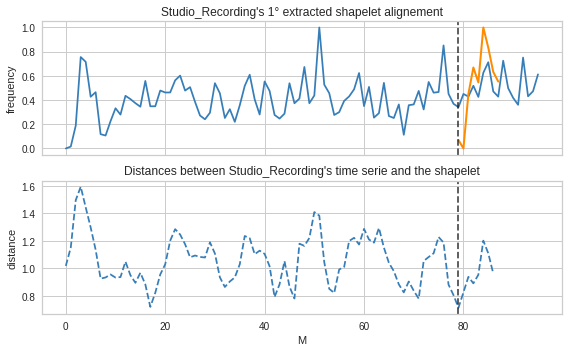

pos=24	min_value=0.8671722333259673


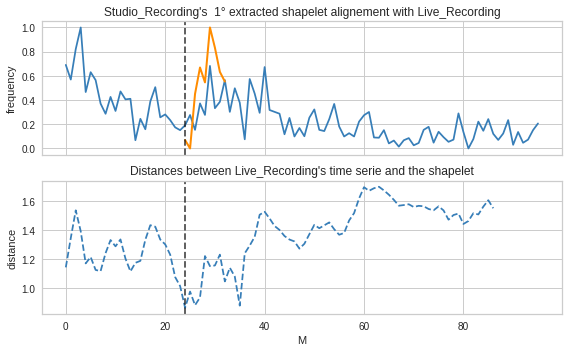


--------------------------------------------------------------------------------------------------

pos=33	min_value=0.7144420401128332


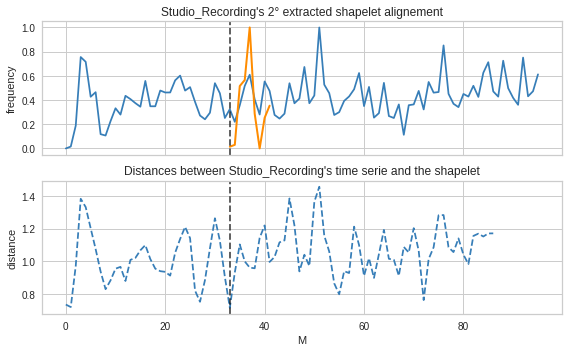

pos=25	min_value=0.7342256677888516


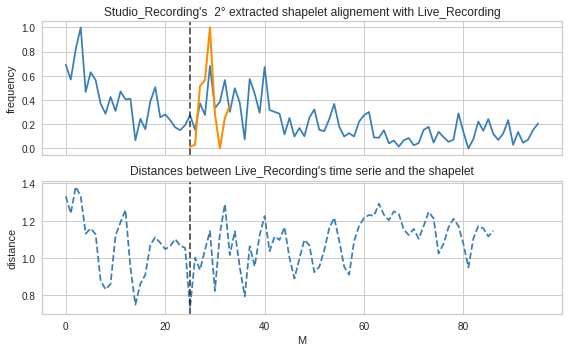


--------------------------------------------------------------------------------------------------



In [332]:
m_shp_clf, m_X_train, m_y_train = plot_most_characteristic_shaplet(g='M', n_shapelets_per_size=-1)

test_ts_id 0 min_distance 0.005338073 pos 7
1.8603515058534215 7
other_test_ts_id 1 min_distance 0.028336963 pos 47
1.6823295320187304 19


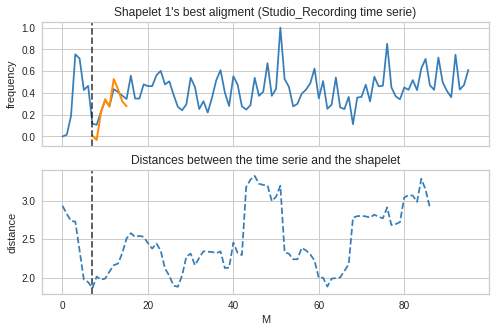

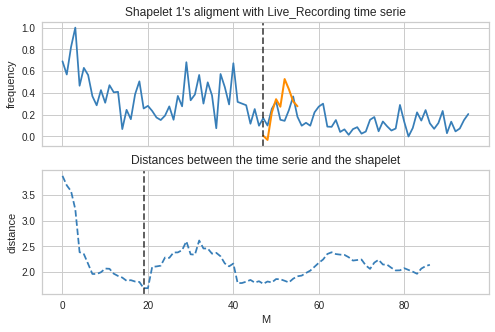

In [334]:
shp_clf = m_shp_clf
X_train = m_X_train
y_train = m_y_train
shap_num = 0  
g = 'M'

# Get the number of extracted shapelets, the (minimal) distances from
# each of the timeseries to each of the shapelets, and the corresponding
# locations (index) where the minimal distance was found
n_shapelets = shp_clf.shapelets_.shape[0]
distances = shp_clf.transform(X_train)
predicted_locations = shp_clf.locate(X_train)

# retrieve current examinated shaplet
shap = shp_clf.shapelets_[shap_num]


# Plot the shapelet and align it on the best matched time series. 
# for each shaplet, keep track of best which ts is best matching with it
min_distances =  {}
for shap_number in range(0, n_shapelets):
    min_distances[shap_number] = (sys.maxsize, -1)
    for i, d in zip(range(0, len(distances)), distances):
        tmp_d = d[shap_number]
        if tmp_d < min_distances[shap_number][0]:
            min_distances[shap_number] = (tmp_d, i)
                    
# retrive shaplet's best TS matching
test_ts_id = min_distances[shap_num][1]  
pos = predicted_locations[test_ts_id, shap_num]
print("test_ts_id", test_ts_id, "min_distance", min_distances[shap_num][0], "pos", pos)


ts_name = None
shap_color = None
if test_ts_id == 0:
    ts_name = "Studio_Recording"
    shap_color = "darkorange"
else:
    ts_name = "Live_Recording"
    shap_color = "mediumseagreen"

# plot aligned shaplet to best matched TS
f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
ax[0].plot(X_train[test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, color=shap_color)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.75)
ax[0].set_title("Shapelet %s\'s best aligment (%s time serie)" % ((shap_num + 1), ts_name))
ax[0].set_ylabel("%s" % ts_column_name)

# calculate the distances from the shapelet to the timeseries ourselves
self_distances = []
time_series = X_train[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    self_distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))

# plot distances from the shapelet to the timeseries ourselves
ax[1].plot(self_distances, linestyle='--')
ax[1].axvline(np.argmin(self_distances), color='k', linestyle='--', alpha=0.75)
ax[1].set_title('Distances between the time serie and the shapelet')
ax[1].set_xlabel("%s" % g)
ax[1].set_ylabel("distance")

print(np.min(self_distances), np.argmin(self_distances))

# plot shaplet's aligment with other TSs (so with its not best match)
other_test_ts_id = None
other_ts_name = None 
if test_ts_id == 0:
    other_test_ts_id = 1
    other_ts_name = "Live_Recording"
else:
    other_test_ts_id = 0
    other_ts_name = "Studio_Recording"
    
pos = predicted_locations[other_test_ts_id, shap_num]
print("other_test_ts_id", other_test_ts_id, "min_distance", distances[other_test_ts_id, shap_num], "pos", pos)

# plot aligned shaplet to min distance
f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
ax[0].plot(X_train[other_test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, color=shap_color)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.75)
ax[0].set_title("Shapelet %s\'s aligment with %s time serie" % ((shap_num + 1), other_ts_name))
ax[0].set_ylabel("%s" % ts_column_name)

# calculate the distances from the shapelet to the timeseries ourselves
self_distances = []
time_series = X_train[other_test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    self_distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))

# plot distances from the shapelet to the timeseries ourselves
ax[1].plot(self_distances, linestyle='--')
ax[1].axvline(np.argmin(self_distances), color='k', linestyle='--', alpha=0.75)
ax[1].set_title('Distances between the time serie and the shapelet')
ax[1].set_xlabel("%s" % g)
ax[1].set_ylabel("distance")

print(np.min(self_distances), np.argmin(self_distances))

plt.show()

In [308]:
def my_plot(other_test_ts_id, pos):
    # plot aligned shaplet to min distance
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
    ax[0].plot(X_train[other_test_ts_id].ravel())
    ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, color=shap_color)
    ax[0].axvline(pos, color='k', linestyle='--', alpha=0.75)
    ax[0].set_title("Shapelet %s\'s aligment with %s time serie" % ((shap_num + 1), other_ts_name))
    ax[0].set_ylabel("%s" % ts_column_name)

    # calculate the distances from the shapelet to the timeseries ourselves
    self_distances = []
    time_series = X_train[other_test_ts_id].ravel()
    for i in range(len(time_series) - len(shap)):
        self_distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))

    # plot distances from the shapelet to the timeseries ourselves
    ax[1].plot(self_distances, linestyle='--')
    ax[1].axvline(np.argmin(self_distances), color='k', linestyle='--', alpha=0.75)
    ax[1].set_title('Distances between the time serie and the shapelet')
    ax[1].set_xlabel("%s" % g)
    ax[1].set_ylabel("distance")


    print(np.min(self_distances), np.argmin(self_distances))

    plt.show()

In [309]:
predicted_locations

array([[ 7, 12],
       [47,  5]])

1.8603515058534215 7


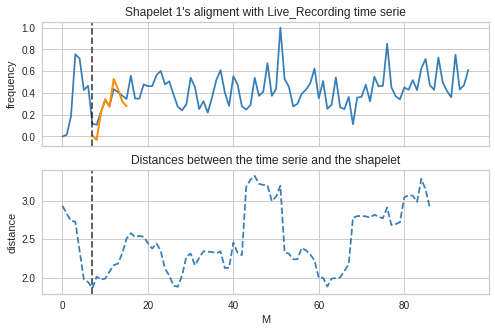

In [325]:
my_plot(0, 7)

1.8603515058534215 7


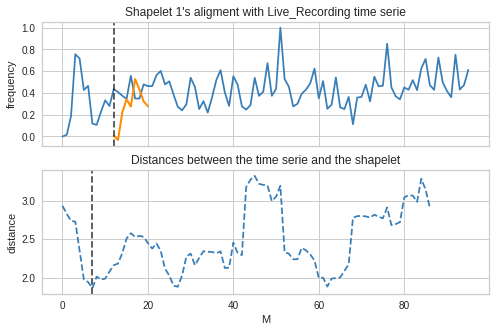

In [326]:
my_plot(0, 12)

1.8603515058534215 7


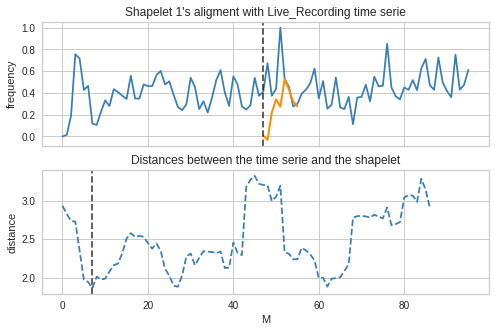

In [327]:
my_plot(0, 47)

1.8603515058534215 7


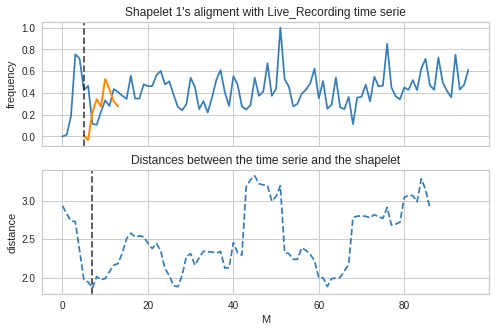

In [328]:
my_plot(0, 5)

1.8603515058534215 7


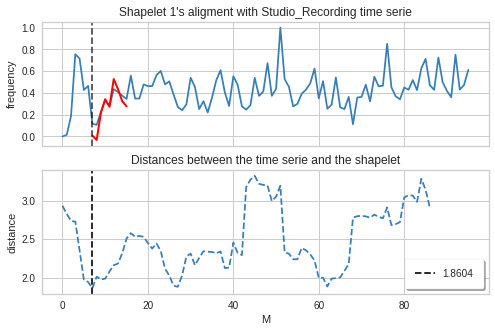

1.6823295320187304 19


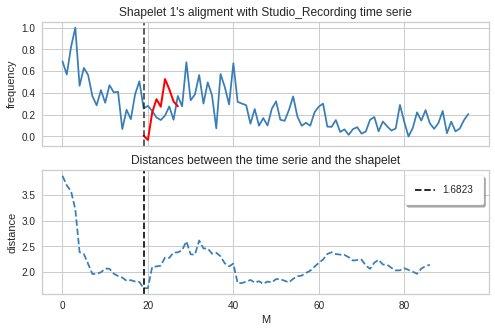

0.6258428229704848 12


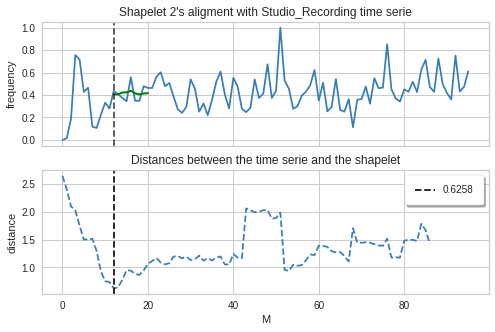

0.9592032933744125 5


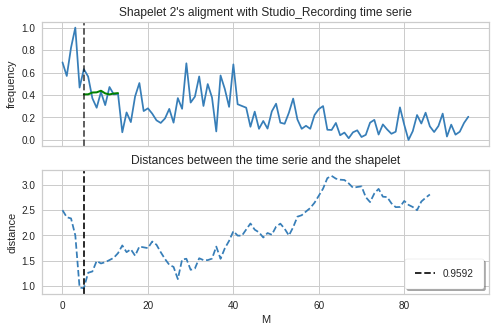

In [360]:
shp_clf = m_shp_clf
X_train = m_X_train
y_train = m_y_train
g = 'M'
colors = ['red', 'green', 'black', 'gold', 'blue']

# Get the number of extracted shapelets, the (minimal) distances from
# each of the timeseries to each of the shapelets, and the corresponding
# locations (index) where the minimal distance was found
n_shapelets = shp_clf.shapelets_.shape[0]

for shap_num in range(0, n_shapelets):
    # retrieve current examinated shaplet
    shap = shp_clf.shapelets_[shap_num]
    shap_color = colors[shap_num]
    
    for test_ts_id in range(0, X_train.shape[0]):
        # calculate the distances from the shapelet to the timeserie
        self_distances = []
        time_series = X_train[test_ts_id].ravel()
        for i in range(len(time_series) - len(shap)):
            self_distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))

        pos = np.argmin(self_distances)

        # plot aligned shaplet to best matched TS
        f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
        ax[0].plot(X_train[test_ts_id].ravel())
        ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, color=shap_color)
        ax[0].axvline(pos, color='k', linestyle='--', alpha=0.75)
        ax[0].set_title("Shapelet %s\'s aligment with %s time serie" % ((shap_num + 1), ts_name))
        ax[0].set_ylabel("%s" % ts_column_name)

        # plot distances from the shapelet to the timeseries ourselves
        ax[1].plot(self_distances, linestyle='--')
        ax[1].axvline(np.argmin(self_distances), color='k', linestyle='--', alpha=1, 
                                                             label="%s" % round(np.min(self_distances), 4))
        ax[1].set_title('Distances between the time serie and the shapelet')
        ax[1].set_xlabel("%s" % g)
        ax[1].set_ylabel("distance")

        print(np.min(self_distances), np.argmin(self_distances))

        plt.legend(loc='best', framealpha=1, borderpad=1, frameon=True, fancybox=True, shadow=True)
        plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

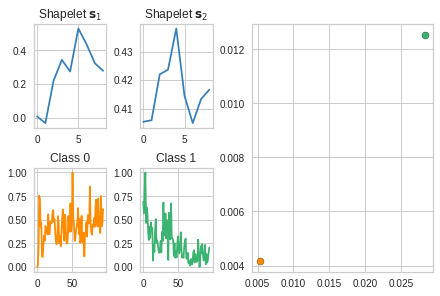

In [244]:
from matplotlib import cm
from itertools import product

shp_clf = m_shp_clf
X_train = m_X_train
y_train = m_y_train

# We will plot our distances in a 2D space
n_shapelets = shp_clf.shapelets_.shape[0]
distances = shp_clf.transform(X_train).reshape((-1, 2))
weights, biases = shp_clf.get_weights('classification')

# Create a grid for our two shapelets on the left and distances on the right
viridis = ['darkorange', 'mediumseagreen']
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax3a = fig.add_subplot(gs[1, :2])
fig_ax3b = fig.add_subplot(gs[1, 2:4])
# fig_ax3c = fig.add_subplot(gs[2, :2])
# fig_ax3d = fig.add_subplot(gs[2, 2:4])
fig_ax4 = fig.add_subplot(gs[:, 4:])

# Plot our two shapelets on the left side
fig_ax1.plot(shp_clf.shapelets_[0])
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(shp_clf.shapelets_[1])
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')


# Create the time series of each class
for i, subfig in enumerate([fig_ax3a, fig_ax3b]):
    for k, ts in enumerate(X_train[y_train == i]):
        subfig.plot(ts.flatten(), c=viridis[i])
        subfig.set_title('Class {}'.format(i))

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(np.unique(y_train)):
    fig_ax4.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=viridis[i],
                    edgecolors='k',
                    label='Class {}'.format(y))
    
    
# Create a meshgrid of the decision boundaries
xmin = np.min(distances[:, 0]) - 0.1
xmax = np.max(distances[:, 0]) + 0.1
ymin = np.min(distances[:, 1]) - 0.1
ymax = np.max(distances[:, 1]) + 0.1
xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin)/200),
                        np.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(np.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                           for i in range(4)]))
Z = np.array(Z).reshape(xx.shape)
cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series')
plt.show()

<h6> W </h6>

In [30]:
# w_shp_clf = plot_most_characteristic_shaplet(g='W', n_shapelets_per_size=-1)

<h6> D </h6>

In [315]:
# d_shp_clf = plot_most_characteristic_shaplet(g='D', n_shapelets_per_size=-1)

<h6> H </h6>

In [316]:
# h_shp_clf = plot_most_characteristic_shaplet(g='H', n_shapelets_per_size=-1)